## Light Gradient Boosting (LightGBM)

Light gradient boost algorithm is another improved generalized gradient boosting algorithm  that can be used for both classification and regression tasks, which uses decision trees as base learners.

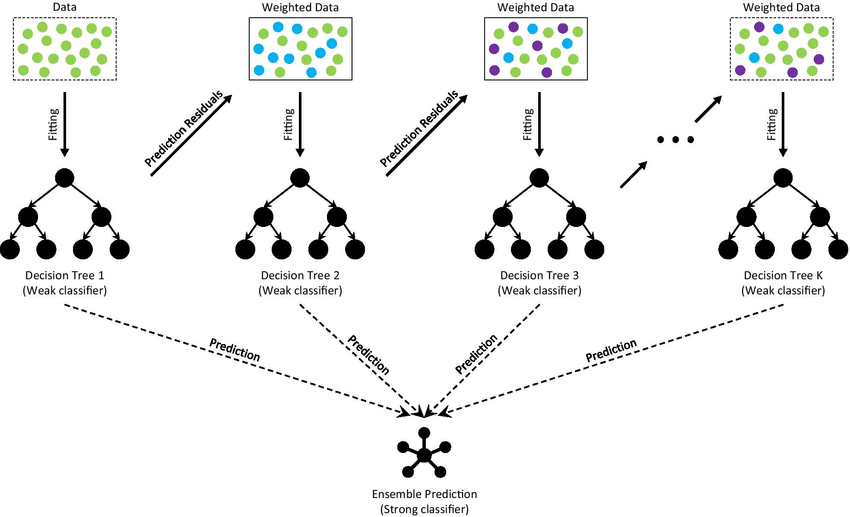

Unlike traditional gradient boosting and XGBoost algorithm, LightGBM further introduces two new concepts that further speeds up XGBoost models with the help of <b>Gradient-based one sided sampling (GOSS) and Exclusive Feature Bundling (EFB)</b>. In addition LightGBM also supports data-based and voting-based parallel computing.

<b>Requirement of feature scaling: No</b>

<b>Robust to outliers: Yes</b>

<b>Is multicollinearity an issue?: No</b>

<b>Advantages of LightGBM:</b>
1. Lower memory usage than XGBoost
2. Suitable for larger datasets
3. Faster training speed and higher efficiency than XGBoost
4. Parallel computing that results in fast execution time

<b>Disadvantages of LightGBM:</b>
1. Prone to overfitting using leaf-wise algorithm on smaller datasets.
2. Large space of hyperparameter tuning required
3. Difficult to interpret final model

<b>How does LightGBM handle missing values?:</b> Missing values are ignored during a split in LightGBM first, before allocating them to whichever side that reduces the loss the most.

<b>How does LightGBM handle categorical data?:</b> Integer-encoded categorical data is supported, where split happened using sorted histogram according to cummulated values (sum_gradient/sum_hessian)

Extra Notes:
1. Dart booster in LightGBM involves adding dropout techniques from neural networks to boosted trees to solve overfitting issue
2. LightGBM grows trees leaf wise (based on max_delta_step hyperparameter)
- leaf-wise algorithms tend to achieve lower loss than level-wise algorithms when fixing number of leaves. For small datasets, leaf-wise algorithms are more likely to overfit than level-wise algorithms. Thus, max_depth hyperparameter is used to reduce overfitting

More details about LightGBM can be found in the following official documentation:
https://lightgbm.readthedocs.io/en/latest/index.html

## Histogram method for LightGBM

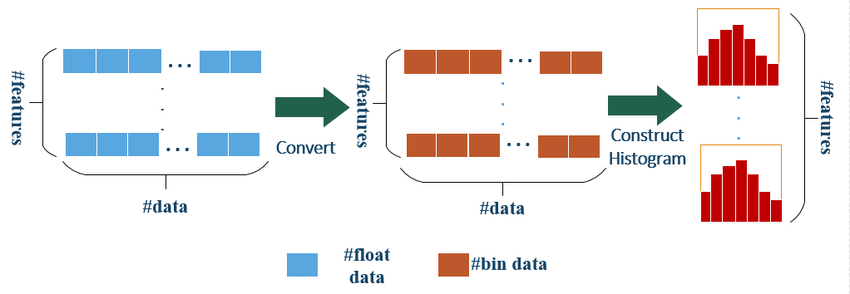

The Histogram algorithm in LightGBM tries to discretize every feature in the dataset into sets of bins.

For continuous features, statistics is obtained based on gradient and hessian for the histogram containing K bins for every feature. Best split point that provides the maximum gain when separate k bins into two parts is used.

For categorical features, there are two possible methods:
1. If number of distinct values is at most maximum number of categories for one-hot encoding (<b>max_cat_to_onehot</b> hyperparameter), then one vs other method is used to identify the split that maximizes output gain.

2. If number of distinct values is higher than maximum number of categories for one-hot encoding (max_cat_to_onehot hyperparameter), then statistics is obtained based on gradient and hessian for each category for every feature, followed by sorting categories based on value of (sum(gradients)/sum(Hessians)). Try to find possible split points that maximizes output gain <b>max_cat_threshold</b> times (maximum number of bins to search).

Advantages:
1. Reduce cost of calculating the gain for each split
2. Use histogram subtraction for further speedup
3. Reduce memory usage by replacing continuous values with discrete bins
4. Reduce communication cost for distributed learning

## GOSS (Gradient-based one-sided sampling) method for LightGBM

GOSS method further reduces RAM usage and to save computing time for finding the best features and best split points.

GOSS sorts data instances according to absolute value of samples' gradients, then it retains top n% instances of samples with high gradients and randomly samples b% instances with low gradients. Samples with small gradients will be amplified by a constant multiplier to shift model focus to more under-trained instances.

## Exclusive Feature Bundling

For several features that are mutually exclusive (created from one-hot encoding), these features can be bundled together to reduce risk of curse of dimensionality.

## Optimization in distributed learning

While XGBoost only supports feature-based parallel learning, LightGBM supports feature-based, data-based and voting-based parallel learning.

### Feature-based parallel learning

Steps in feature-based parallel learning:

i) Workers find local best split point {feature, threshold} on local feature set.

ii) Communicate local best splits with each other and get the best one.

iii) Perform best split.

Disadvantage: Still suffers from computation overhead for splits when sample size is large.

### Data-based parallel learning

While traditional data-based parallel learning merges global histograms from all local histograms, LightGBM uses reduce scatter to merge histograms of different, non-overlapping features for different workers. Histogram subtraction is used to speed up training by communicating histograms only for one leaf and obtain neighbor's histograms by subtraction as well.

Steps in data-based parallel learning:

i) Workers find local best split point on local merged histograms

ii) Communicate local best splits with each other and get the best one.

iii) Perform best split

Disadvantage: Has communication cost of O(0.5 * #feature * #bin)

### Voting-based parallel learning

Voting-based parallel learning further reduces communication cost to constant cost by using two-stage voting.

In [1]:
# Import all required Python libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, load_wine
from skopt import BayesSearchCV
from lightgbm import LGBMClassifier, LGBMRegressor
from skopt.space import Real, Integer, Categorical
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold

More details related to Exploratory Data Analysis for both regression and classification problem statement can be found in the following Jupyter Notebook within the same folder: EDA_Regression.ipynb and EDA_Classification.ipynb

## LightGBM for regression

<b>Important hyperparameters for LGBMRegressor</b>:
1. boosting_type: booster algorithm to use for LightGBM (gbdt, dart, goss)
2. reg_lambda: l2 regularization term on weights
3. reg_alpha: l1 regularization term on weights
4. drop_rate: Fraction of previous trees to drop (for dart booster)
5. max_depth: Maximum depth of decision tree
6. subsample: Fraction of samples used to fit individual base learners
7. subsample_freq: Frequency of subsample
- Note that subsample and subsample_freq will not work with "goss" booster
8. learning_rate: Weight applied to each regressor at each boosting iteration. Higher learning rate increases contribution of each regressor. (Tradeoff between learning_rate and n_estimators values)
9. n_estimators: Maximum number of estimators before boosting algorithm terminates
10. num_leaves: Maximum number of tree leaves for base learners
11. min_child_samples: Minimum number of samples required in leaf node
12. min_split_gain: Minimum loss reduction required to make further partition on leaf node (Post-pruning approach)
13. objective : Specifies the learning task and the related learning objective. Represents the loss function to be minimized in the formula. ('regression', 'regression_l1', 'huber', 'mape')

In [2]:
data = fetch_california_housing()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
y.name = 'Median House Value ($100000)'

In [3]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = KFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_rmse, test_rmse = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,
                               scoring= make_scorer(mean_squared_error, squared=False),refit=True, n_jobs=3)
        search.fit(X_train,y_train)
        val_rmse.append(search.best_score_)
        print(f'Validation RMSE for fold {fold+1}:',search.best_score_)
        print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
        y_pred = search.best_estimator_.predict(X_test)
        test_rmse.append(mean_squared_error(y_test,y_pred,squared=False))
        print(f'Test RMSE for fold {fold+1}:',mean_squared_error(y_test,y_pred,squared=False))
    print('----------------------')
    print('Average validation RMSE score:', np.mean(val_rmse))
    print('Average test RMSE score:', np.mean(test_rmse))

In [4]:
reg = LGBMRegressor(random_state=120)
pipeline = Pipeline(steps=[])
pipeline.steps.append(('regression',reg))
search_space = dict()
search_space['regression__learning_rate'] = Real(0.01,0.3,'log-uniform')
search_space['regression__max_depth'] = Integer(3,12)
search_space['regression__num_leaves'] = Integer(8,4096)
search_space['regression__min_child_samples'] = Integer(5,100)
search_space['regression__drop_rate'] = Real(0.0001,1,'log-uniform')
search_space['regression__reg_lambda'] = Real(0.1,100,'log-uniform')
search_space['regression__reg_alpha'] = Real(0.1,100,'log-uniform')
search_space['regression__min_split_gain'] = Real(0.1,15,'log-uniform')        
search_space['regression__boosting_type'] = Categorical(['goss'])
nested_cv(X, y, pipeline, search_space)

Validation RMSE for fold 1: 0.7453209572367642
Best hyperparameters for fold 1: OrderedDict([('regression__boosting_type', 'goss'), ('regression__drop_rate', 0.011064235889065266), ('regression__learning_rate', 0.011883440027030854), ('regression__max_depth', 11), ('regression__min_child_samples', 51), ('regression__min_split_gain', 0.637234127067797), ('regression__num_leaves', 1006), ('regression__reg_alpha', 1.207140471106423), ('regression__reg_lambda', 7.849774666676685)])
Test RMSE for fold 1: 0.6388427197176596
Validation RMSE for fold 2: 0.778626766630764
Best hyperparameters for fold 2: OrderedDict([('regression__boosting_type', 'goss'), ('regression__drop_rate', 0.023274680814125023), ('regression__learning_rate', 0.011992665041605222), ('regression__max_depth', 10), ('regression__min_child_samples', 56), ('regression__min_split_gain', 3.170633065634687), ('regression__num_leaves', 2562), ('regression__reg_alpha', 1.1023965006700005), ('regression__reg_lambda', 98.07745828862

In [5]:
reg = LGBMRegressor(random_state=120)
pipeline = Pipeline(steps=[])
pipeline.steps.append(('regression',reg))
search_space = dict()
search_space['regression__learning_rate'] = Real(0.01,0.3,'log-uniform')
search_space['regression__max_depth'] = Integer(3,12)
search_space['regression__num_leaves'] = Integer(8,4096)
search_space['regression__min_child_samples'] = Integer(5,100)
search_space['regression__drop_rate'] = Real(0.0001,1,'log-uniform')
search_space['regression__reg_lambda'] = Real(0.1,100,'log-uniform')
search_space['regression__reg_alpha'] = Real(0.1,100,'log-uniform')
search_space['regression__min_split_gain'] = Real(0.1,15,'log-uniform')        
search_space['regression__boosting_type'] = Categorical(['gbdt','dart'])
search_space['regression__subsample'] = Real(0.5,1,'log-uniform')
search_space['regression__subsample_freq'] = Integer(1,10)
nested_cv(X, y, pipeline, search_space)

Validation RMSE for fold 1: 0.8211977080372515
Best hyperparameters for fold 1: OrderedDict([('regression__boosting_type', 'dart'), ('regression__drop_rate', 0.02490517423702013), ('regression__learning_rate', 0.033334457133103776), ('regression__max_depth', 6), ('regression__min_child_samples', 68), ('regression__min_split_gain', 0.9082165340301284), ('regression__num_leaves', 3789), ('regression__reg_alpha', 7.284930938230205), ('regression__reg_lambda', 85.15042370569701), ('regression__subsample', 0.5426612635950984), ('regression__subsample_freq', 6)])
Test RMSE for fold 1: 0.7707947224877714
Validation RMSE for fold 2: 2.08364820158139
Best hyperparameters for fold 2: OrderedDict([('regression__boosting_type', 'dart'), ('regression__drop_rate', 0.011711932632974313), ('regression__learning_rate', 0.19766498310194963), ('regression__max_depth', 5), ('regression__min_child_samples', 8), ('regression__min_split_gain', 8.35265440069248), ('regression__num_leaves', 1989), ('regression

## LightGBM for Classification

<b>Important hyperparameters for LGBMClassifier</b>:
1. boosting_type: booster algorithm to use for LightGBM (gbdt, dart, goss)
2. reg_lambda: l2 regularization term on weights
3. reg_alpha: l1 regularization term on weights
4. drop_rate: Fraction of previous trees to drop (for dart booster)
5. max_depth: Maximum depth of decision tree
6. subsample: Fraction of samples used to fit individual base learners
7. subsample_freq: Frequency of subsample
- Note that subsample and subsample_freq will not work with "goss" booster
8. learning_rate: Weight applied to each classifier at each boosting iteration. Higher learning rate increases contribution of each regressor. (Tradeoff between learning_rate and n_estimators values)
9. n_estimators: Maximum number of estimators before boosting algorithm terminates
10. num_leaves: Maximum number of tree leaves for base learners
11. min_child_samples: Minimum number of samples required in leaf node
12. min_split_gain: Minimum loss reduction required to make further partition on leaf node (Post-pruning approach)
13. objective : Specifies the learning task and the related learning objective. Represents the loss function to be minimized in the formula. ('binary', 'multiclass')

<b>Methods to handle imbalanced dataset for classification</b>:
1. Resampling techniques (Oversampling/Combination of Oversampling and Undersampling - Less suitable for larger datasets due to high computation time)
2. Set is_unbalance paramter to True

In [6]:
data = load_wine()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
y.name = 'Wine_Class'

In [7]:
X.nunique()

alcohol                         126
malic_acid                      133
ash                              79
alcalinity_of_ash                63
magnesium                        53
total_phenols                    97
flavanoids                      132
nonflavanoid_phenols             39
proanthocyanins                 101
color_intensity                 132
hue                              78
od280/od315_of_diluted_wines    122
proline                         121
dtype: int64

In [8]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_f1, test_f1 = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
        search.fit(X_train,y_train)
        val_f1.append(search.best_score_)
        print(f'Validation F1 score for fold {fold+1}:',search.best_score_)
        print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
        y_pred = search.best_estimator_.predict(X_test)
        test_f1.append(f1_score(y_test,y_pred, average='macro'))
        print(f'Test F1 score for fold {fold+1}:',f1_score(y_test,y_pred, average='macro'))
        print()
        cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        cmd.ax_.set_title(f"Confusion Matrix - LGBMClassifier (Fold {fold+1})")
        plt.grid(False)
        plt.show()
        print()
    print('----------------------')
    print('Average validation F1 score:', np.mean(val_f1))
    print('Average test F1 score:', np.mean(test_f1))

Validation F1 score for fold 1: 0.9091812182214349
Best hyperparameters for fold 1: OrderedDict([('classification__boosting_type', 'goss'), ('classification__drop_rate', 0.006674596386682165), ('classification__learning_rate', 0.1456762764433518), ('classification__max_depth', 7), ('classification__min_child_samples', 29), ('classification__min_split_gain', 0.8460959863208065), ('classification__num_leaves', 3500), ('classification__reg_alpha', 0.27082332230013034), ('classification__reg_lambda', 5.323663236063278)])
Test F1 score for fold 1: 0.8688034188034188



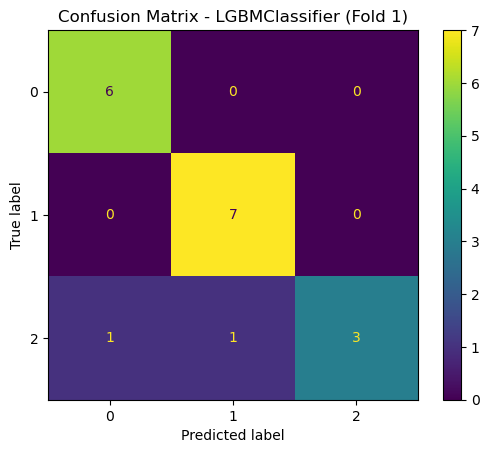


Validation F1 score for fold 2: 0.9425371326847973
Best hyperparameters for fold 2: OrderedDict([('classification__boosting_type', 'goss'), ('classification__drop_rate', 0.0024500692102104897), ('classification__learning_rate', 0.10728852265076244), ('classification__max_depth', 5), ('classification__min_child_samples', 16), ('classification__min_split_gain', 0.2841692292433191), ('classification__num_leaves', 1576), ('classification__reg_alpha', 9.753519631637277), ('classification__reg_lambda', 0.2800656336611504)])
Test F1 score for fold 2: 1.0



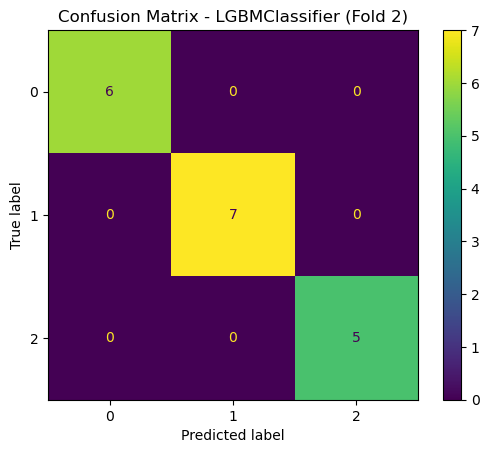


Validation F1 score for fold 3: 0.9608118246848896
Best hyperparameters for fold 3: OrderedDict([('classification__boosting_type', 'goss'), ('classification__drop_rate', 0.006939627694511627), ('classification__learning_rate', 0.018000898490317923), ('classification__max_depth', 11), ('classification__min_child_samples', 15), ('classification__min_split_gain', 0.3742768867157163), ('classification__num_leaves', 3074), ('classification__reg_alpha', 1.4918977102093836), ('classification__reg_lambda', 3.018941350528384)])
Test F1 score for fold 3: 0.9487179487179486



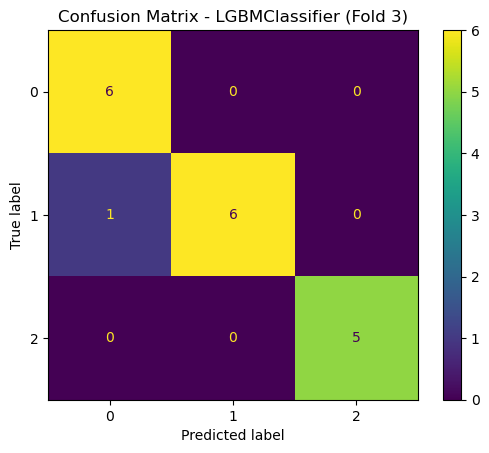


Validation F1 score for fold 4: 0.9280398217766639
Best hyperparameters for fold 4: OrderedDict([('classification__boosting_type', 'goss'), ('classification__drop_rate', 0.019944032338709717), ('classification__learning_rate', 0.17624953941165908), ('classification__max_depth', 11), ('classification__min_child_samples', 5), ('classification__min_split_gain', 2.369128438341298), ('classification__num_leaves', 3700), ('classification__reg_alpha', 11.649863208325824), ('classification__reg_lambda', 5.070103895811665)])
Test F1 score for fold 4: 1.0



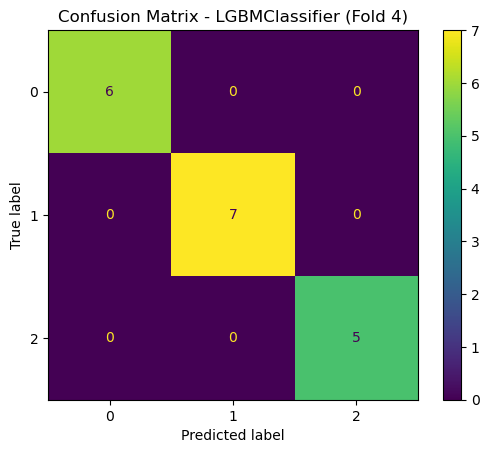


Validation F1 score for fold 5: 0.9297643162545711
Best hyperparameters for fold 5: OrderedDict([('classification__boosting_type', 'goss'), ('classification__drop_rate', 0.07555796039061496), ('classification__learning_rate', 0.04813132154416652), ('classification__max_depth', 7), ('classification__min_child_samples', 14), ('classification__min_split_gain', 0.6280479546692413), ('classification__num_leaves', 605), ('classification__reg_alpha', 17.62609185263456), ('classification__reg_lambda', 1.7170254689068307)])
Test F1 score for fold 5: 1.0



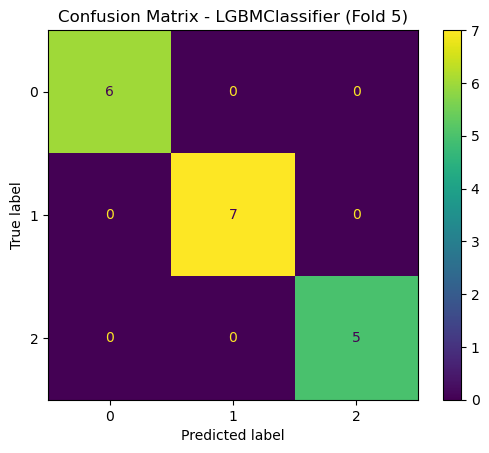


Validation F1 score for fold 6: 0.9422315214941548
Best hyperparameters for fold 6: OrderedDict([('classification__boosting_type', 'goss'), ('classification__drop_rate', 0.002583813615289725), ('classification__learning_rate', 0.1429386648018898), ('classification__max_depth', 3), ('classification__min_child_samples', 6), ('classification__min_split_gain', 0.3716760415755987), ('classification__num_leaves', 674), ('classification__reg_alpha', 2.5713740821229805), ('classification__reg_lambda', 15.540097143779198)])
Test F1 score for fold 6: 1.0



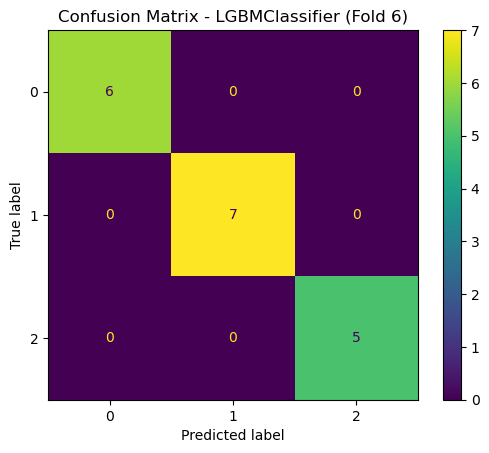


Validation F1 score for fold 7: 0.9142532291117463
Best hyperparameters for fold 7: OrderedDict([('classification__boosting_type', 'goss'), ('classification__drop_rate', 0.020905986489323868), ('classification__learning_rate', 0.017045296346104043), ('classification__max_depth', 10), ('classification__min_child_samples', 6), ('classification__min_split_gain', 1.8670651020086395), ('classification__num_leaves', 2212), ('classification__reg_alpha', 5.891754058766045), ('classification__reg_lambda', 2.6956982360491772)])
Test F1 score for fold 7: 0.8916666666666667



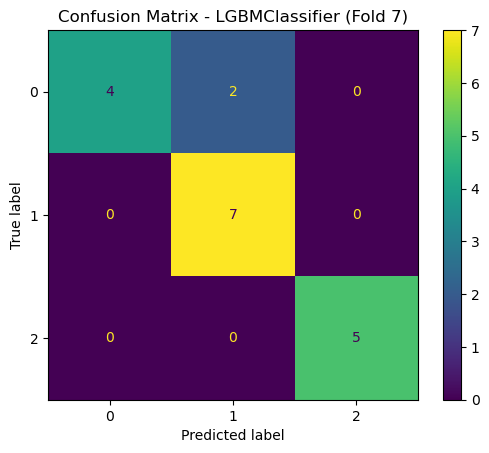


Validation F1 score for fold 8: 0.9510466718088202
Best hyperparameters for fold 8: OrderedDict([('classification__boosting_type', 'goss'), ('classification__drop_rate', 0.00012851231976104997), ('classification__learning_rate', 0.038483078982628344), ('classification__max_depth', 7), ('classification__min_child_samples', 8), ('classification__min_split_gain', 0.15794341576290022), ('classification__num_leaves', 1436), ('classification__reg_alpha', 1.1364063696745996), ('classification__reg_lambda', 0.3533216579798315)])
Test F1 score for fold 8: 1.0



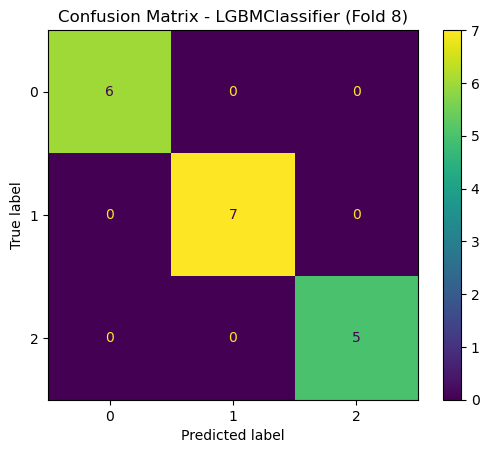


Validation F1 score for fold 9: 0.9569946954627262
Best hyperparameters for fold 9: OrderedDict([('classification__boosting_type', 'goss'), ('classification__drop_rate', 0.10018327001263318), ('classification__learning_rate', 0.028503348778329995), ('classification__max_depth', 11), ('classification__min_child_samples', 15), ('classification__min_split_gain', 2.255013418344473), ('classification__num_leaves', 3850), ('classification__reg_alpha', 0.1925477971164197), ('classification__reg_lambda', 5.886927499038999)])
Test F1 score for fold 9: 0.9373219373219372



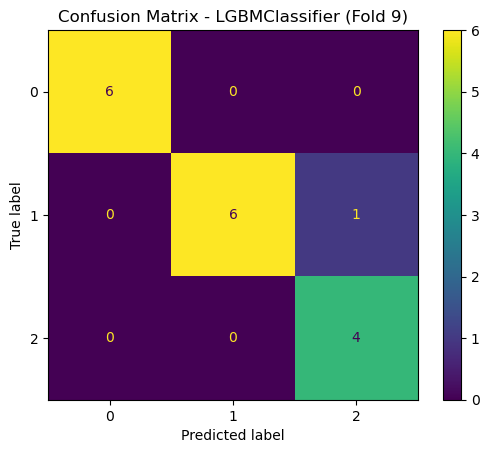


Validation F1 score for fold 10: 0.974765511391437
Best hyperparameters for fold 10: OrderedDict([('classification__boosting_type', 'goss'), ('classification__drop_rate', 0.7361169363479271), ('classification__learning_rate', 0.08639478928142434), ('classification__max_depth', 7), ('classification__min_child_samples', 10), ('classification__min_split_gain', 1.2486921685853594), ('classification__num_leaves', 3458), ('classification__reg_alpha', 0.11468581321008231), ('classification__reg_lambda', 0.23207373387771285)])
Test F1 score for fold 10: 0.8850408850408851



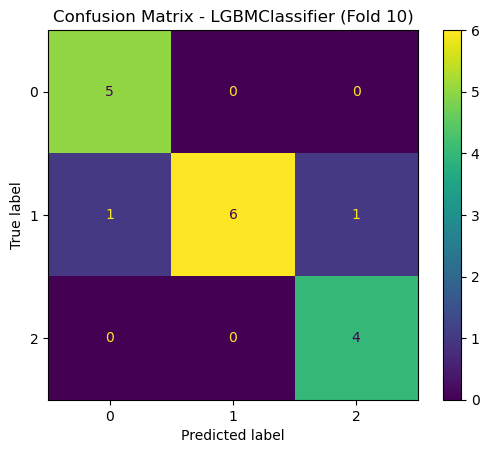


----------------------
Average validation F1 score: 0.9409625942891241
Average test F1 score: 0.9531550856550857


In [9]:
clf = LGBMClassifier(random_state=120, is_unbalance=True)
pipeline = Pipeline(steps=[])
pipeline.steps.append(('classification',clf))
search_space = dict()
search_space['classification__learning_rate'] = Real(0.01,0.3,'log-uniform')
search_space['classification__max_depth'] = Integer(3,12)
search_space['classification__num_leaves'] = Integer(8,4096)
search_space['classification__min_child_samples'] = Integer(5,100)
search_space['classification__drop_rate'] = Real(0.0001,1,'log-uniform')
search_space['classification__reg_lambda'] = Real(0.1,100,'log-uniform')
search_space['classification__reg_alpha'] = Real(0.1,100,'log-uniform')
search_space['classification__min_split_gain'] = Real(0.1,15,'log-uniform')        
search_space['classification__boosting_type'] = Categorical(['goss'])
nested_cv(X, y, pipeline, search_space)

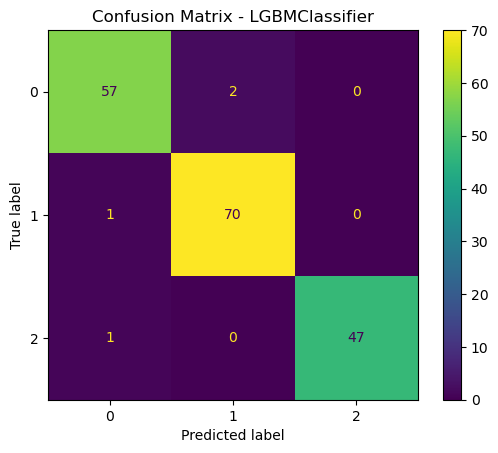

In [10]:
search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10, scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
search.fit(X,y)
y_pred = search.best_estimator_.predict(X)
cmd = ConfusionMatrixDisplay.from_predictions(y, y_pred)
cmd.ax_.set_title("Confusion Matrix - LGBMClassifier")
plt.grid(False)
plt.show()

Validation F1 score for fold 1: 0.943506429709777
Best hyperparameters for fold 1: OrderedDict([('classification__boosting_type', 'gbdt'), ('classification__drop_rate', 0.00041003919910799133), ('classification__learning_rate', 0.16950071067983594), ('classification__max_depth', 5), ('classification__min_child_samples', 42), ('classification__min_split_gain', 2.489277595439441), ('classification__num_leaves', 1294), ('classification__reg_alpha', 0.4193829283997817), ('classification__reg_lambda', 3.504956834474923), ('classification__subsample', 0.5910147939469974), ('classification__subsample_freq', 2)])
Test F1 score for fold 1: 1.0



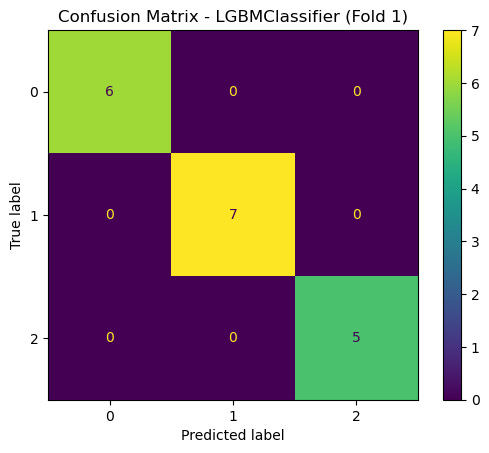


Validation F1 score for fold 2: 0.9564214842306107
Best hyperparameters for fold 2: OrderedDict([('classification__boosting_type', 'dart'), ('classification__drop_rate', 0.0002435782782032611), ('classification__learning_rate', 0.19864189067856175), ('classification__max_depth', 7), ('classification__min_child_samples', 28), ('classification__min_split_gain', 0.6449292086167673), ('classification__num_leaves', 254), ('classification__reg_alpha', 0.27051011436406425), ('classification__reg_lambda', 3.0742661450375968), ('classification__subsample', 0.6286852805568178), ('classification__subsample_freq', 6)])
Test F1 score for fold 2: 1.0



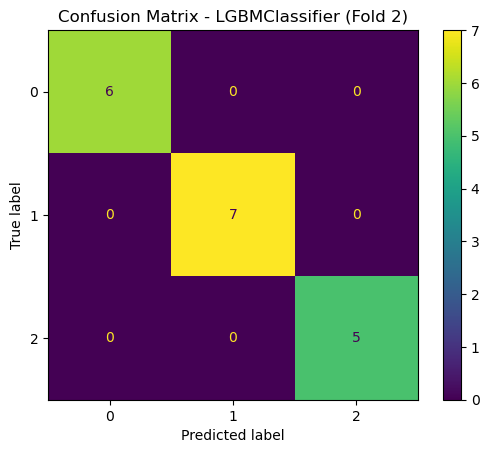


Validation F1 score for fold 3: 0.9554840506589958
Best hyperparameters for fold 3: OrderedDict([('classification__boosting_type', 'dart'), ('classification__drop_rate', 0.0033149627865614643), ('classification__learning_rate', 0.03196073572125132), ('classification__max_depth', 11), ('classification__min_child_samples', 55), ('classification__min_split_gain', 0.33526856984002923), ('classification__num_leaves', 2125), ('classification__reg_alpha', 2.0034825763312494), ('classification__reg_lambda', 6.720388123695873), ('classification__subsample', 0.9268090947173854), ('classification__subsample_freq', 3)])
Test F1 score for fold 3: 0.9487179487179486



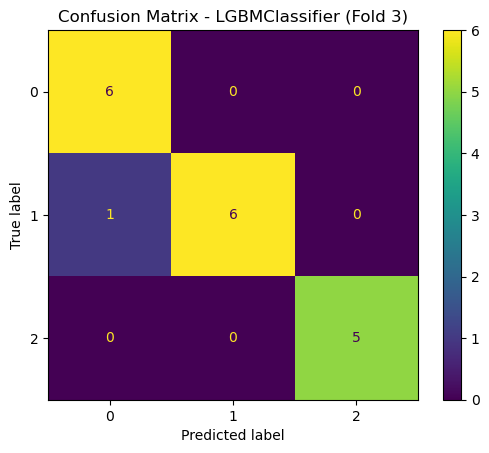


Validation F1 score for fold 4: 0.935351953341723
Best hyperparameters for fold 4: OrderedDict([('classification__boosting_type', 'dart'), ('classification__drop_rate', 0.09842332891794803), ('classification__learning_rate', 0.024656839984703322), ('classification__max_depth', 8), ('classification__min_child_samples', 35), ('classification__min_split_gain', 3.441372903854531), ('classification__num_leaves', 428), ('classification__reg_alpha', 0.5141097672708717), ('classification__reg_lambda', 0.14458459995344894), ('classification__subsample', 0.8026070858825565), ('classification__subsample_freq', 7)])
Test F1 score for fold 4: 1.0



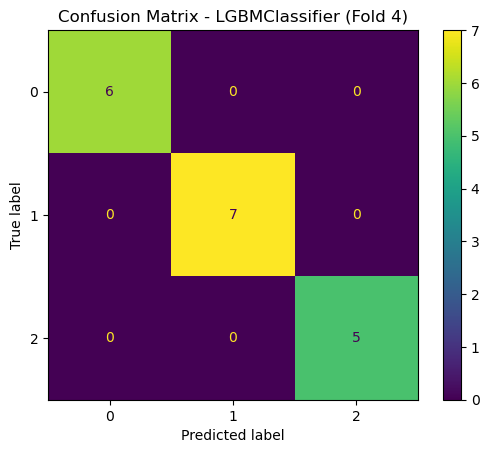


Validation F1 score for fold 5: 0.9501375526055833
Best hyperparameters for fold 5: OrderedDict([('classification__boosting_type', 'gbdt'), ('classification__drop_rate', 0.0038384926172270357), ('classification__learning_rate', 0.05926701195883319), ('classification__max_depth', 7), ('classification__min_child_samples', 18), ('classification__min_split_gain', 0.12386821926942461), ('classification__num_leaves', 3328), ('classification__reg_alpha', 0.6331386367214943), ('classification__reg_lambda', 0.12301174486719565), ('classification__subsample', 0.7973432803882745), ('classification__subsample_freq', 3)])
Test F1 score for fold 5: 1.0



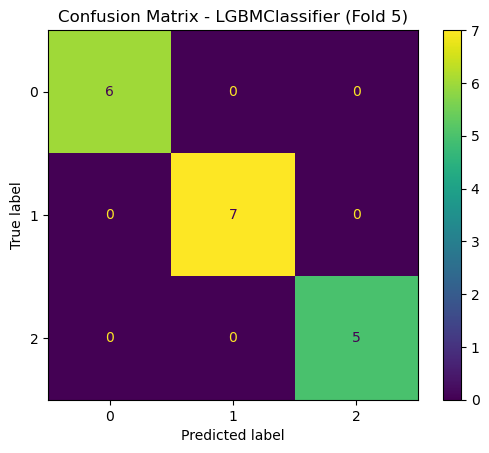


Validation F1 score for fold 6: 0.9299648113843386
Best hyperparameters for fold 6: OrderedDict([('classification__boosting_type', 'dart'), ('classification__drop_rate', 0.00016117660083189313), ('classification__learning_rate', 0.25045765199015446), ('classification__max_depth', 10), ('classification__min_child_samples', 21), ('classification__min_split_gain', 0.7653129014313349), ('classification__num_leaves', 33), ('classification__reg_alpha', 2.9747418912691126), ('classification__reg_lambda', 1.6809399773526303), ('classification__subsample', 0.9241604228315138), ('classification__subsample_freq', 3)])
Test F1 score for fold 6: 1.0



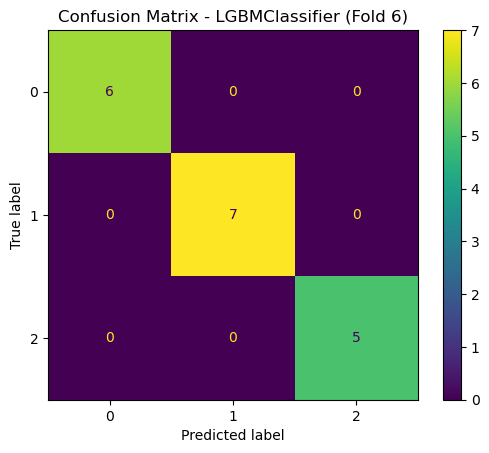


Validation F1 score for fold 7: 0.9033762653294218
Best hyperparameters for fold 7: OrderedDict([('classification__boosting_type', 'dart'), ('classification__drop_rate', 0.0008402485232650665), ('classification__learning_rate', 0.2122768348335021), ('classification__max_depth', 4), ('classification__min_child_samples', 63), ('classification__min_split_gain', 0.3418481105472816), ('classification__num_leaves', 3396), ('classification__reg_alpha', 2.2938383922405476), ('classification__reg_lambda', 36.207915085168864), ('classification__subsample', 0.9678871367168354), ('classification__subsample_freq', 1)])
Test F1 score for fold 7: 0.9474747474747475



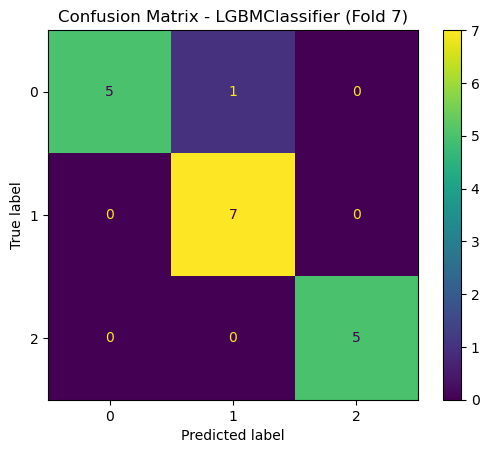


Validation F1 score for fold 8: 0.9634537783898398
Best hyperparameters for fold 8: OrderedDict([('classification__boosting_type', 'dart'), ('classification__drop_rate', 0.004555541571974396), ('classification__learning_rate', 0.2716669108277849), ('classification__max_depth', 8), ('classification__min_child_samples', 26), ('classification__min_split_gain', 0.12559092626003043), ('classification__num_leaves', 380), ('classification__reg_alpha', 0.12632342509138803), ('classification__reg_lambda', 0.7973409724555103), ('classification__subsample', 0.6704564432836521), ('classification__subsample_freq', 9)])
Test F1 score for fold 8: 0.9440559440559441



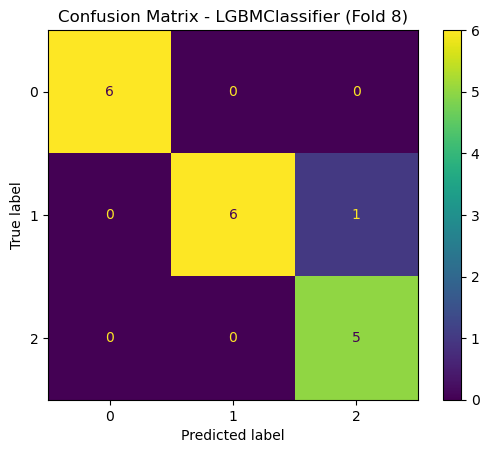


Validation F1 score for fold 9: 0.9444683770618172
Best hyperparameters for fold 9: OrderedDict([('classification__boosting_type', 'gbdt'), ('classification__drop_rate', 0.0006842290677283327), ('classification__learning_rate', 0.012629326335808376), ('classification__max_depth', 7), ('classification__min_child_samples', 29), ('classification__min_split_gain', 0.7081656606024838), ('classification__num_leaves', 3725), ('classification__reg_alpha', 0.8950416010230775), ('classification__reg_lambda', 4.4622790168610145), ('classification__subsample', 0.5096941661678152), ('classification__subsample_freq', 4)])
Test F1 score for fold 9: 0.8850408850408851



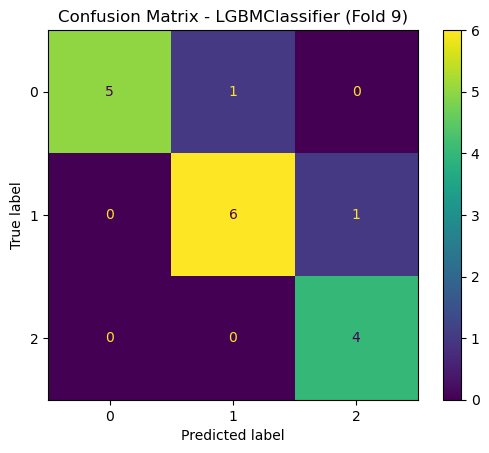


Validation F1 score for fold 10: 0.9635707465120127
Best hyperparameters for fold 10: OrderedDict([('classification__boosting_type', 'dart'), ('classification__drop_rate', 0.384998958991847), ('classification__learning_rate', 0.2636669347682196), ('classification__max_depth', 5), ('classification__min_child_samples', 27), ('classification__min_split_gain', 0.5130194622724314), ('classification__num_leaves', 293), ('classification__reg_alpha', 0.6625874707296122), ('classification__reg_lambda', 3.668685022274123), ('classification__subsample', 0.5122629404751726), ('classification__subsample_freq', 7)])
Test F1 score for fold 10: 0.8850408850408851



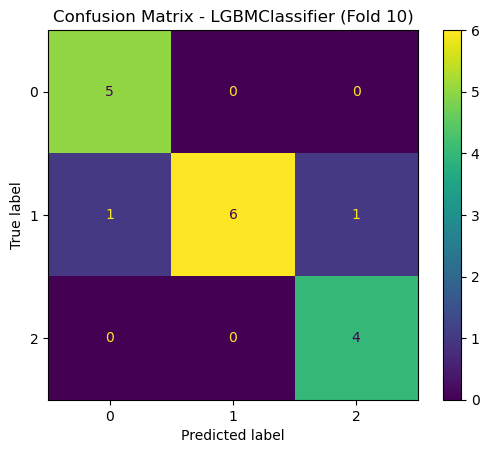


----------------------
Average validation F1 score: 0.944573544922412
Average test F1 score: 0.9610330410330411


In [11]:
clf = LGBMClassifier(random_state=120, is_unbalance=True)
pipeline = Pipeline(steps=[])
pipeline.steps.append(('classification',clf))
search_space = dict()
search_space['classification__learning_rate'] = Real(0.01,0.3,'log-uniform')
search_space['classification__max_depth'] = Integer(3,12)
search_space['classification__num_leaves'] = Integer(8,4096)
search_space['classification__min_child_samples'] = Integer(5,100)
search_space['classification__drop_rate'] = Real(0.0001,1,'log-uniform')
search_space['classification__subsample'] = Real(0.5,1,'log-uniform')
search_space['classification__subsample_freq'] = Integer(1,10)
search_space['classification__reg_lambda'] = Real(0.1,100,'log-uniform')
search_space['classification__reg_alpha'] = Real(0.1,100,'log-uniform')
search_space['classification__min_split_gain'] = Real(0.1,15,'log-uniform')        
search_space['classification__boosting_type'] = Categorical(['gbdt','dart'])
nested_cv(X, y, pipeline, search_space)

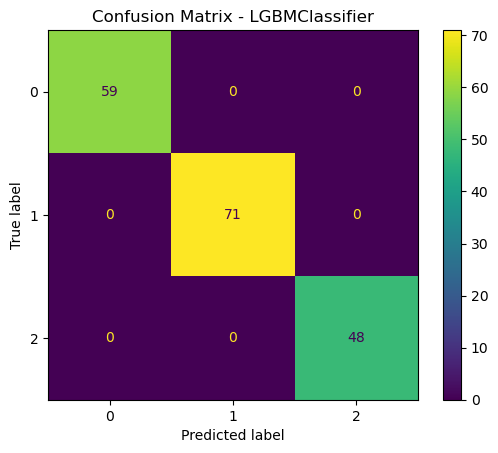

In [12]:
search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10, scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
search.fit(X,y)
y_pred = search.best_estimator_.predict(X)
cmd = ConfusionMatrixDisplay.from_predictions(y, y_pred)
cmd.ax_.set_title("Confusion Matrix - LGBMClassifier")
plt.grid(False)
plt.show()